# Exercício 9

## Arthur Magalhães - 12629595

## Atividade 1

O arquivo zspec.dat contém redshifts espectroscópicos entre 0 e 0.5. Quantas estruturas você acha que tem ao longo da linha de visada? Use técnicas de modelagem da distribuição de probabilidades para abordar o problema. Considere a regra de Knuth, KDE e GMM.

## Desenvolvimento

In [6]:
zspec <- read.table('zspec.dat', header = TRUE)  #lendo a tabela
dim(zspec)
head(zspec)

spec <- zspec$zspec #transferindo os dados para uma lista

[1] 170   1

,zspec
,<dbl>
1,0.05585507
2,0.07712834
3,0.07821175
4,0.05470439
5,0.05387363
6,0.04669622


### - Regra de Knuth

Primeiramente vamos analisar os dados utilizando a regra de Knuth. Esta regra é um método bayesiano assumindo uma verossimilhança multinomial e um prior não-informativo posterior do número de bins M com contagens nk
 em cada bin, para determinarmos a quantidade de bins ótima na visualização do histograma.
 
 Da forma:
 
$P(M|D) = N log M + log \left[\Gamma \left( \frac{M}{2}\right)\right]- M log \left[\Gamma \left( \frac{1}{2}\right)\right] - log \left[\Gamma \left(\Gamma \left(N + \frac{M}{2}\right)\right)\right] + \sum_{k = 1}^M log\left[\Gamma \left( n_k + \frac{1}{2}\right)\right]$

In [31]:
# regra de Knuth: teste com até 100 bins

# regra de Knuth
# https://arxiv.org/pdf/physics/0605197.pdf
# optBINS finds the optimal number of bins for a one-dimensionaldata set using the posterior probability for the number of bins
# This algorithm uses a brute-force search trying every possible bin number in the given range.  This can of course be improved.
# Generalization to multidimensional data sets is straightforward.
## Usage:
#           optBINS = function(data,maxM)
# Where:
#           data is a (1,N) vector of data points
#           maxM is the maximum number of bins to consider
## Ref: K.H. Knuth. 2012. Optimal data-based binning for histograms
# and histogram-based probability density models, Entropy.
optBINS = function(data,maxM){

N = length(data)

# Simply loop through the different numbers of bins
# and compute the posterior probability for each.

logp = rep(0,N)

for(M in 2:maxM){

# Bin the data (equal width bins here)
n = table(cut(data, breaks = M))

soma = 0
for(k in 1:M){soma = soma + lgamma(n[k]+0.5)}

logp[M] = N*log(M) + lgamma(M/2) - lgamma(N+M/2) - M*lgamma(1/2)+ soma
#sum(lgamma(n+0.5))
#print(c(M,logp[M]))
}
return(logp)
}

a = optBINS(spec,200)

Mknuth = which(a == max(a))
Mknuth

[1] 104

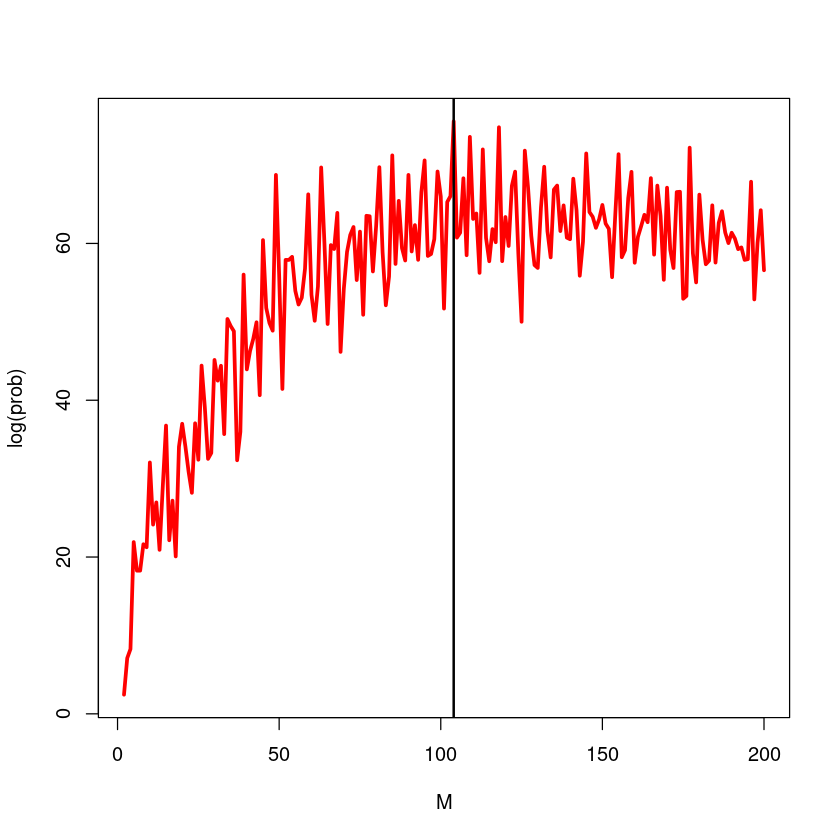

In [32]:
par(mfrow = c(1,1))
plot(seq(2,200,1),a[2:200],type='l',xlab='M', ylab='log(prob)',col='red',lwd=3)
abline(v=104,lwd=2)

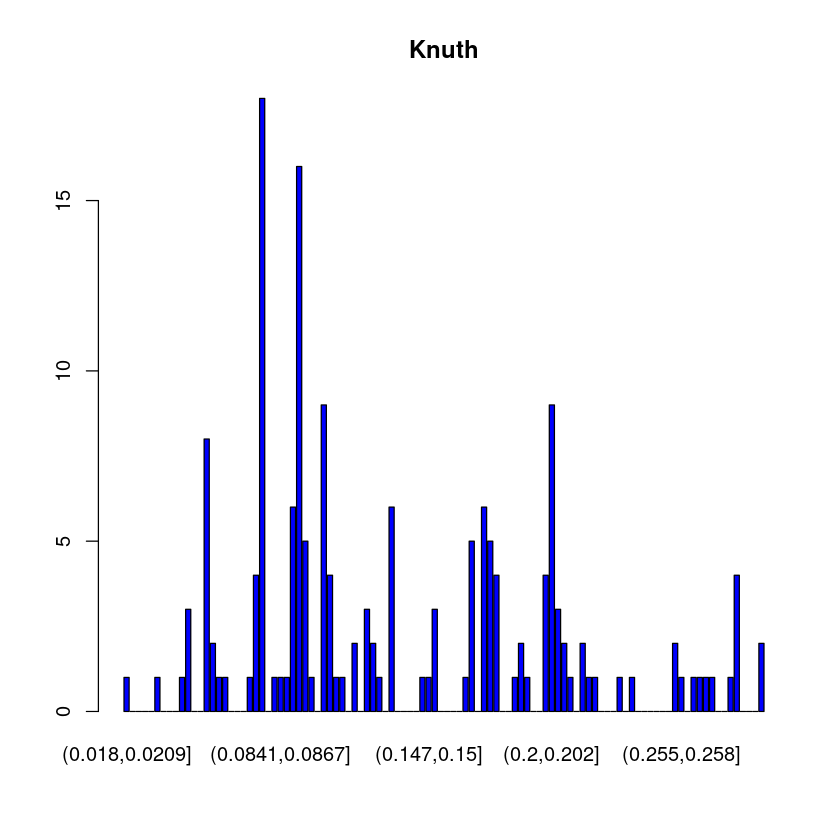

In [42]:
plot(cut(spec, breaks = Mknuth),col='blue', main = 'Knuth')

Temos então que a regra de Knuth nos fornece um valor de 104 bins, podemos ver este valor através do gráfico de 200 iterações e pegando o valor máximo de M. Em seguido plotamos um histograma com este número de bins. O resultado é desfavorável, de forma a ter um espaçamento muito grande e sendo muito difícil de determinar qualquer estrutura com certeza.

### - KDE

Agora utilizei o a técnica de KDE (kernel density estimation), que permite representar uma distribuição de forma contínua (ao contrário da representação discreta de um histograma).

A função de densidade utlizada pelo KDE é:

$f(x;h) = \frac{1}{Nh^D} \sum_{i = 1}^N K \left(\frac{d(x,x_i)}{h}\right)$

em que K(u) é a função Kernel, d representa a distância entre dois pontos, h é a largura de banda que define o tamanho do kernel, N é o número de pontos.

A largura de banda (h) é a constante mais importante a ser determinada, por isso irei fazer de duas formas para comparar o resultado.

[1] 0.01054

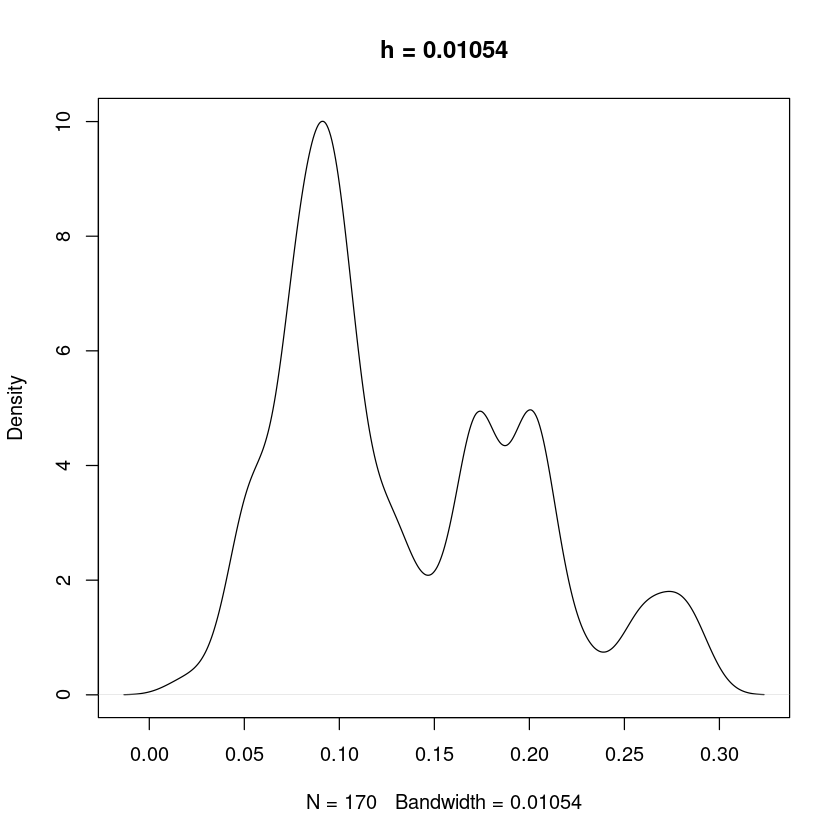

In [53]:
h_bw = bw.SJ(spec) ## a largura de banda SJ (Sheather & Jones 1991) é geralmente considerada a escolha default
round(h_bw,5)

plot(density(spec, bw = bw.SJ(spec)), main = "h = 0.01054" )

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


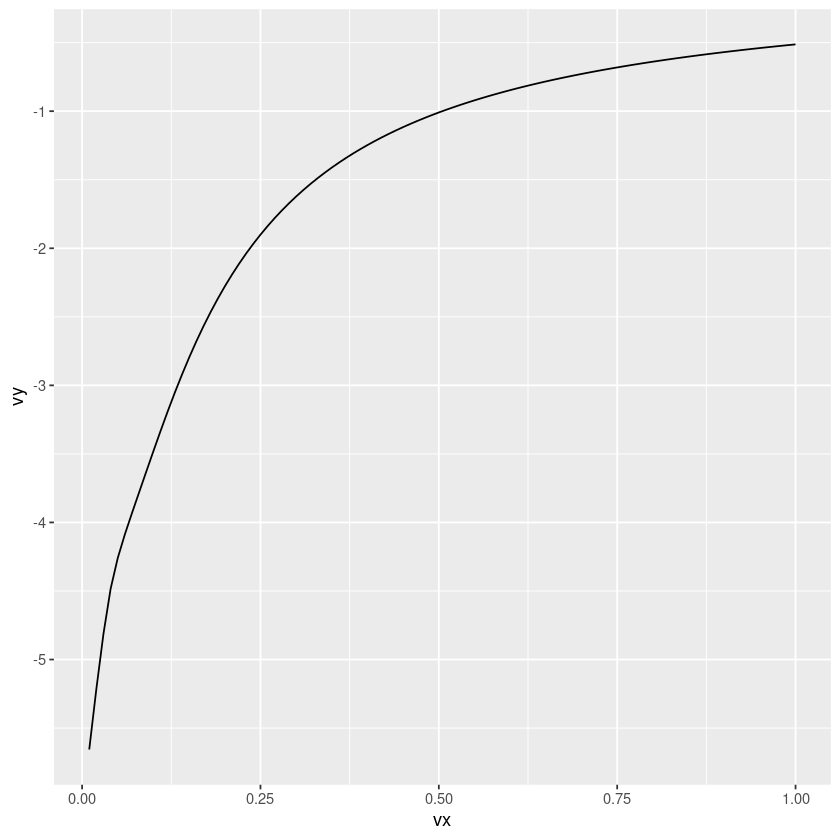

In [54]:
# https://www.r-bloggers.com/cross-validation-for-kernel-density-estimation/
# o default é o kernel gaussiano
X = spec
J=function(h){
  fhat=Vectorize(function(x) density(X,from=x,to=x,n=1,bw=h)$y)
  fhati=Vectorize(function(i) density(X[-i],from=X[i],to=X[i],n=1,bw=h)$y)
  F=fhati(1:length(X))
  return(integrate(function(x) fhat(x)^2,-Inf,Inf)$value-2*mean(F))
}

vx=seq(.01,1,by=.01)
vy=Vectorize(J)(vx)
df=data.frame(vx,vy)

par(mfrow = c(2,2))
library(ggplot2)
qplot(vx,vy,geom="line",data=df)

In [55]:
# optimal value:
a = optimize(J,interval=c(.01,1))
a
hopt = a$minimum
hopt

$minimum
[1] 0.0100652

$objective
[1] -5.65099

[1] 0.0100652

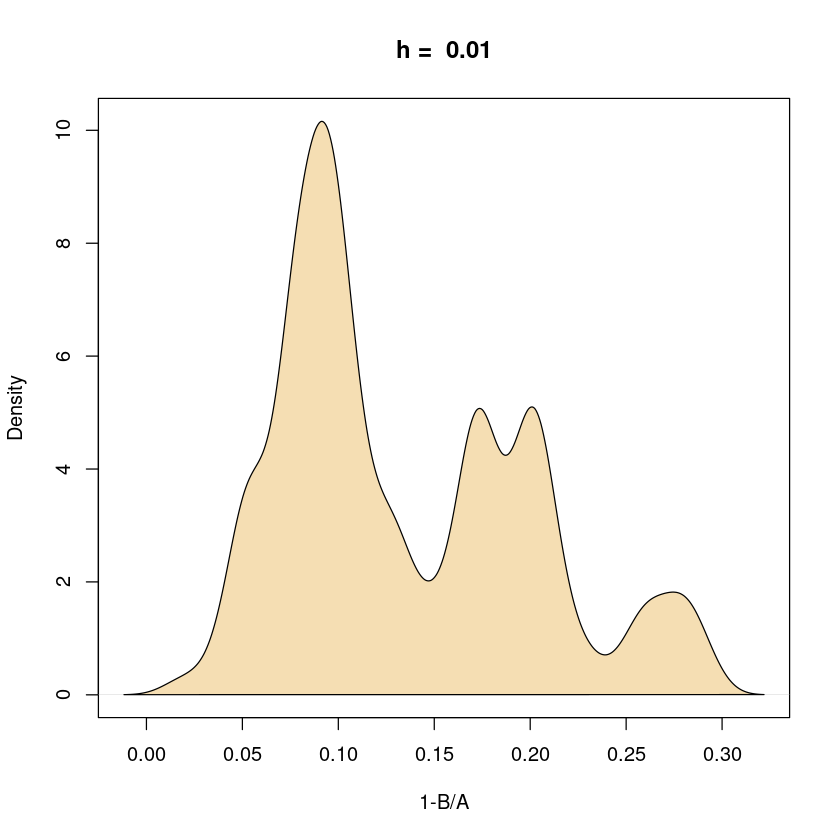

In [56]:
hopt=round(hopt,3)

# visualização:
par(mfrow = c(1,1))
y = density(spec, bw = hopt)
plot(y,xlab = '1-B/A', type = "n", main = sprintf(paste('h = ',hopt)))
polygon(y, col = "wheat")

Utilizando a largura de banda SJ (Sheather & Jones 1991), cheguei ao valor de $h = 0.01054$ , e foi possível ver claramente 4 estruturas no gráfico. 

Em seguida utilizei um método mais robusto para determinar a largura de banda por validação cruzada, deixando um de fora. Este método consiste em determinar o valor de h que minimiza a expressão:

$E \left[\int [\hat{f_h}(x) - f(x)]^2 dx\right]$

O valor encontrado com este método foi de h = 0.01, que é simplesmente um arredondamento do valor anterior. Por serem muito semelhantes os gráficos também são idênticos, apresentando 4 estruturas.

### -GMM

Por fim, utilizei o método GMM (Gaussian Mixture Models), em que a distribuição pode ser modelada como uma soma de gaussianas. A densidade de n pontos numa distribuição modelada por M gaussianas é dada por:

$\rho(x) = n \sum_{i=1}^M \omega_i N(x|\mu_i, \Sigma_i)$

onde μi e Σi são a média e a matriz de covariância da i-ésima gaussiana, $\omega_i$ é o peso da i-ésima gaussiana. Logo para se obter os parâmetros das gaussianas pode-se maximizar a verossimilhança, que é proporcional a ρ.

Temos então:

In [66]:
library(mclust)

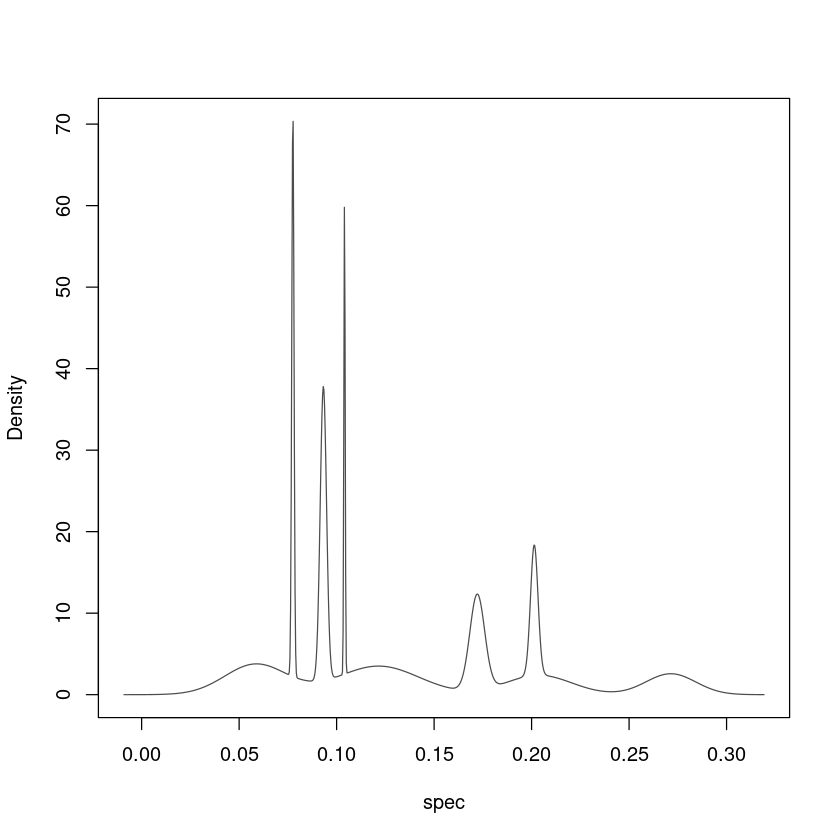

In [60]:
set.seed(12629595)

# vamos usar a função densityMclust()
modelo = densityMclust(spec)

In [61]:
summary(modelo)

------------------------------------------------------- 
Density estimation via Gaussian finite mixture modeling 
------------------------------------------------------- 

Mclust V (univariate, unequal variance) model with 9 components: 

 log-likelihood   n df     BIC      ICL
       332.4359 170 26 531.341 502.7577

In [62]:
summary(modelo, parameters = TRUE)

------------------------------------------------------- 
Density estimation via Gaussian finite mixture modeling 
------------------------------------------------------- 

Mclust V (univariate, unequal variance) model with 9 components: 

 log-likelihood   n df     BIC      ICL
       332.4359 170 26 531.341 502.7577

Mixing probabilities:
         1          2          3          4          5          6          7 
0.14974308 0.10015764 0.14584194 0.04863827 0.18342929 0.10099759 0.11193136 
         8          9 
0.07682542 0.08243541 

Means:
         1          2          3          4          5          6          7 
0.05856143 0.07757312 0.09320979 0.10405101 0.12153905 0.20368372 0.17212412 
         8          9 
0.20136651 0.27142373 

Variances:
           1            2            3            4            5            6 
2.550300e-04 3.284657e-07 2.598191e-06 1.099342e-07 4.360733e-04 2.849858e-04 
           7            8            9 
1.446176e-05 3.659974e-06 1.641996e-

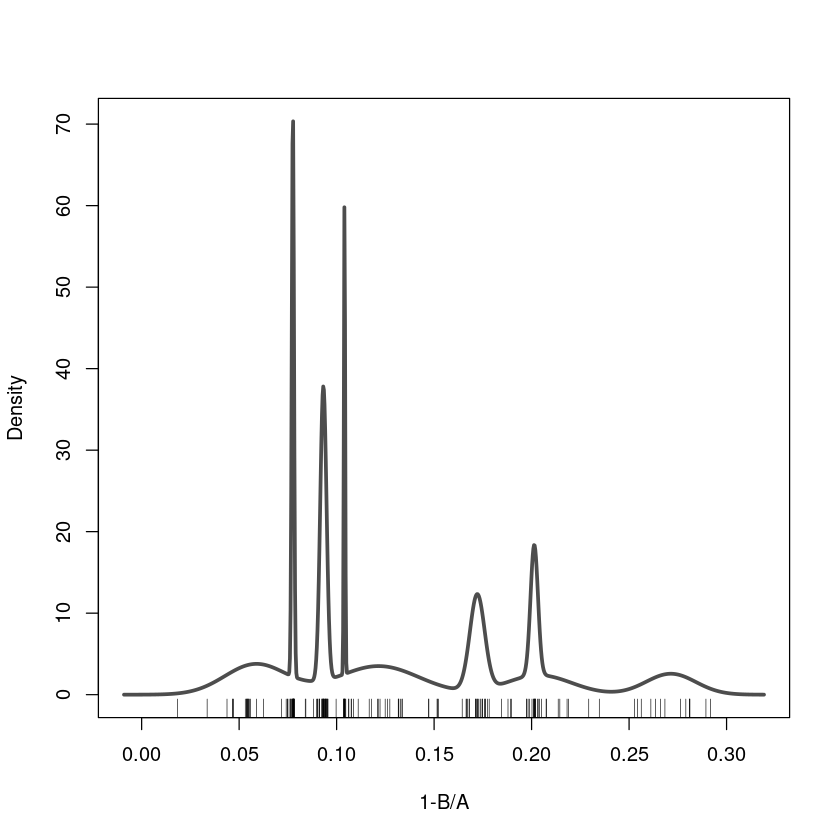

In [63]:
plot(modelo, what="density",xlab="1-B/A",lwd=3)
rug(spec)

Best BIC values:
             V,9        V,8        V,7
BIC      531.341 524.872262 522.971307
BIC diff   0.000  -6.468783  -8.369738

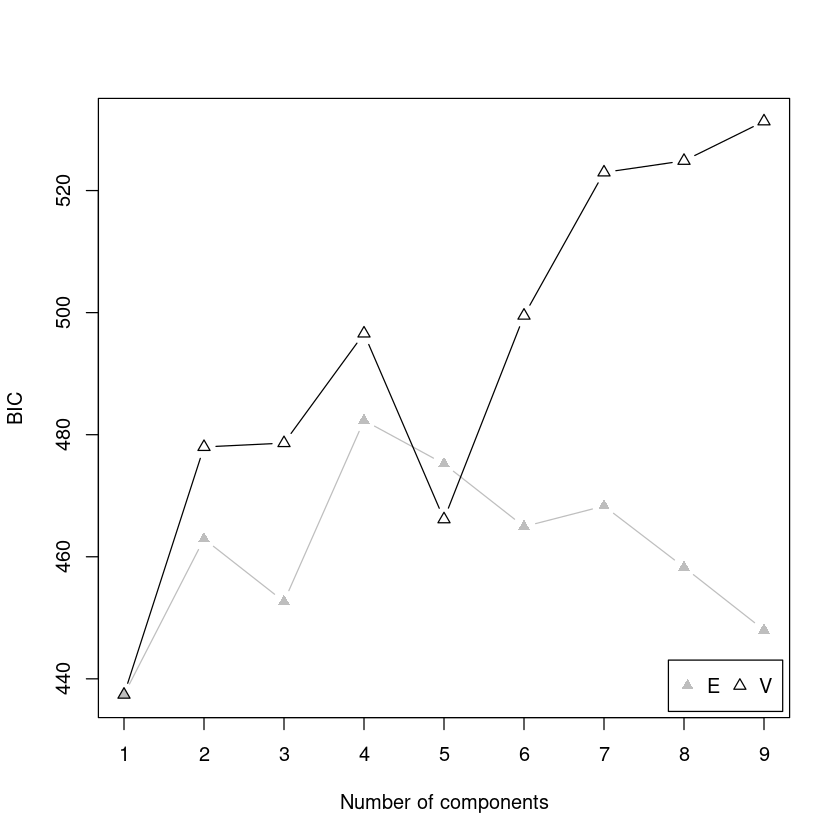

In [65]:
BIC <- mclustBIC(spec)

# melhores modelos:
summary(BIC)

plot(BIC)

Neste método, podemos ver que ele encontrou um valor melhor de gaussiana, em que se maximiza o BIC, ajustando 9 gaussianas diferentes. No entanto é possível ver pelo gráfico que são encontrados 5 estruturas proeminentes. Interessante notar que os dois modelos E e V, do BIC  não coincidem entre si, sendo que V se maximiza em 4 gaussianas.

## Conclusão

Por fim, analisando todos os métodoas para o estudo das estruturas deste conjunto de dados, é possível notar que o primeiro método não foi efetivio para esta visualização, definindo um número muito grande de bins que impedem ua determinação precisa das estruturas.

O segundo método teve a melhor aplicação entre todos, apresentando 4 estruturas proeminentes, e sobreposição ou espaço para questionamentos entre elas.

Já o terceiro método não funcionou tão bem quanto o segundo, fazendo um overfitting de gaussianas, de modo a separar a primeria estrutura em 3 gaussianas diferentes e praticamente sumir com a última.

Portanto, o melhor método para análise ao meu ver seria o **KDE**




## Atividade 2

O arquivo spec100cl.dat contém modelos no referencial de repouso para as mesmas 100 galáxias do arquivo spec100c.dat, mas incluindo tanto o contínuo e linhas de absorção, quanto linhas de emissão.

#### 2.1 Examine os dados fazendo figuras com alguns espectros.


Primeiramente vou ler duas tabelas de dados, tanto com linhas de emissão quanto sem, e irei realizar gráficos comparativos.

In [177]:
tab2 <- read.table('spec100cl.dat', header = TRUE, fill =TRUE)
dim(tab2)
head(tab2)

tab3 <- read.table('spec100c.dat', header = TRUE, fill =TRUE)
dim(tab3)
head(tab3)

[1] 2500  101

,lambda,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3500,0.3225078,0.3858792,0.3611626,0.3356650,0.4374210,0.3162888,0.7123050,0.4057315,0.9070981,⋯,0.5937149,0.3741935,0.8008163,0.3672904,0.4604542,0.7158055,0.4806008,0.3676471,0.3508772,0.8217158
2,3501,0.3459475,0.4080817,0.3828077,0.3600480,0.4374210,0.3382693,0.7105719,0.4042232,0.9060543,⋯,0.5914703,0.3898618,0.8073469,0.3811504,0.4596711,0.7173252,0.4981227,0.3970588,0.3774301,0.8217158
3,3502,0.3645863,0.4276199,0.3995053,0.3790347,0.4437421,0.3560851,0.7175043,0.4132730,0.9175365,⋯,0.6015713,0.4064516,0.8130612,0.3922384,0.4659358,0.7264438,0.5143930,0.4195046,0.3982930,0.8297587
4,3503,0.3756001,0.4444938,0.4124923,0.3904267,0.4551201,0.3671911,0.7313692,0.4283560,0.9363257,⋯,0.6228956,0.4202765,0.8212245,0.4005544,0.4745497,0.7370821,0.5277430,0.4357585,0.4101470,0.8431635
5,3504,0.3758825,0.4440497,0.4149660,0.3903268,0.4563843,0.3683480,0.7348354,0.4268477,0.9331942,⋯,0.6307520,0.4147465,0.8220408,0.3984754,0.4714174,0.7325228,0.5244055,0.4349845,0.4106211,0.8458445
6,3505,0.3674103,0.4205151,0.4032158,0.3770361,0.4412137,0.3600185,0.7071057,0.3996983,0.8966597,⋯,0.5925926,0.3907834,0.8106122,0.3860014,0.4565388,0.7097264,0.5031289,0.4179567,0.3992413,0.8190349


[1] 2500  101

,lambda,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3500,0.3225078,0.3858792,0.3611626,0.3356650,0.4374210,0.3162888,0.7123050,0.4057315,0.9070981,⋯,0.5937149,0.3741935,0.8008163,0.3672904,0.4604542,0.7158055,0.4806008,0.3676471,0.3508772,0.8217158
2,3501,0.3459475,0.4080817,0.3828077,0.3600480,0.4374210,0.3382693,0.7105719,0.4042232,0.9060543,⋯,0.5914703,0.3898618,0.8073469,0.3811504,0.4596711,0.7173252,0.4981227,0.3970588,0.3774301,0.8217158
3,3502,0.3645863,0.4276199,0.3995053,0.3790347,0.4437421,0.3560851,0.7175043,0.4132730,0.9175365,⋯,0.6015713,0.4064516,0.8130612,0.3922384,0.4659358,0.7264438,0.5143930,0.4195046,0.3982930,0.8297587
4,3503,0.3756001,0.4444938,0.4124923,0.3904267,0.4551201,0.3671911,0.7313692,0.4283560,0.9363257,⋯,0.6228956,0.4202765,0.8212245,0.4005544,0.4745497,0.7370821,0.5277430,0.4357585,0.4101470,0.8431635
5,3504,0.3758825,0.4440497,0.4149660,0.3903268,0.4563843,0.3683480,0.7348354,0.4268477,0.9331942,⋯,0.6307520,0.4147465,0.8220408,0.3984754,0.4714174,0.7325228,0.5244055,0.4349845,0.4106211,0.8458445
6,3505,0.3674103,0.4205151,0.4032158,0.3770361,0.4412137,0.3600185,0.7071057,0.3996983,0.8966597,⋯,0.5925926,0.3907834,0.8106122,0.3860014,0.4565388,0.7097264,0.5031289,0.4179567,0.3992413,0.8190349


In [190]:
lambda <- tab2$lambda
gal_1 <- tab2$X1
gal_20 <- tab2$X20
gal_50 <- tab2$X50
gal_70 <- tab2$X70
gal_90 <- tab2$X90
gal_100 <- tab2$X100

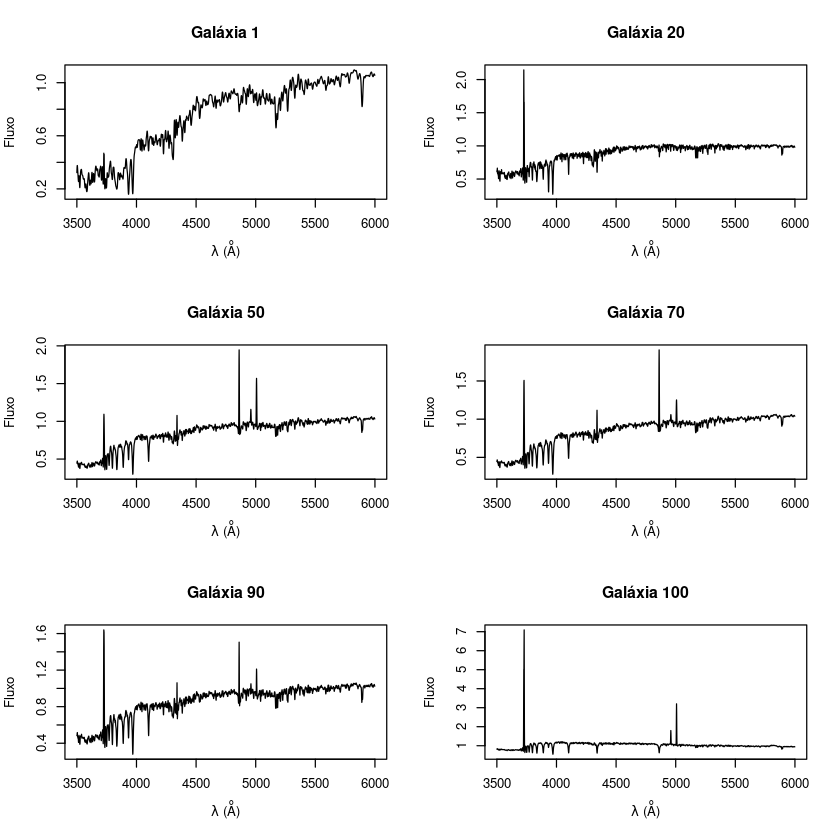

In [191]:
par(mfrow= c(3,2))

plot(lambda, gal_1, type = 'l'  , main = 'Galáxia 1',  xlab=expression(paste(lambda,' (',ring(A),')')), ylab = 'Fluxo')
plot(lambda, gal_20, type = 'l'  , main = 'Galáxia 20',xlab=expression(paste(lambda,' (',ring(A),')')), ylab = 'Fluxo')
plot(lambda, gal_50, type = 'l'  , main = 'Galáxia 50',  xlab=expression(paste(lambda,' (',ring(A),')')), ylab = 'Fluxo')
plot(lambda, gal_70, type = 'l'  , main = 'Galáxia 70', xlab=expression(paste(lambda,' (',ring(A),')')), ylab = 'Fluxo')
plot(lambda, gal_90, type = 'l'  , main = 'Galáxia 90',  xlab=expression(paste(lambda,' (',ring(A),')')), ylab = 'Fluxo')
plot(lambda, gal_100, type = 'l'  , main = 'Galáxia 100',  xlab=expression(paste(lambda,' (',ring(A),')')), ylab = 'Fluxo')

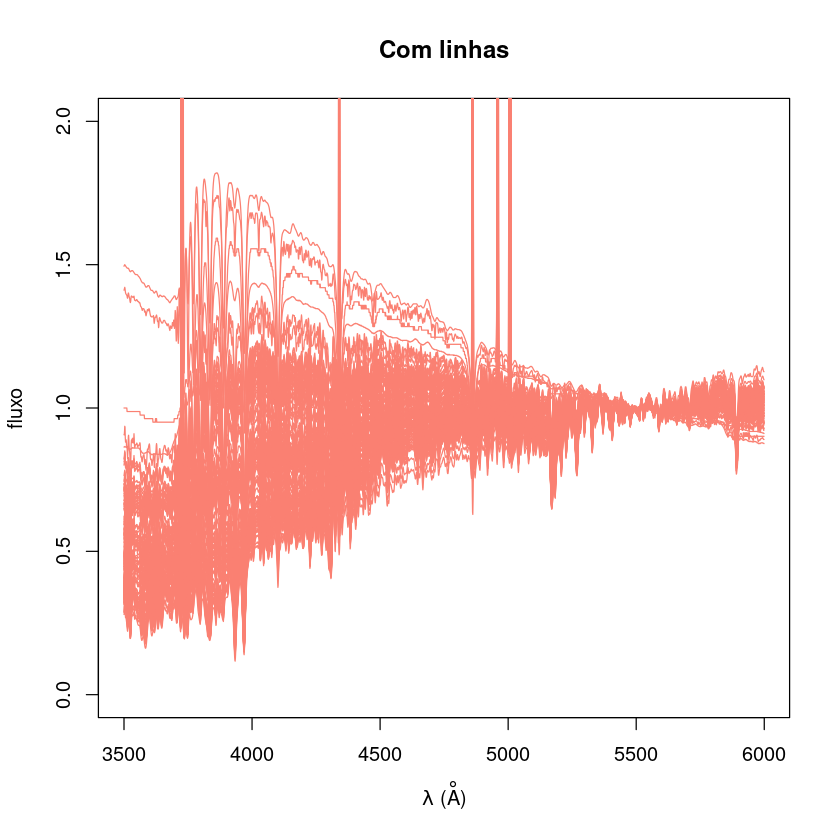

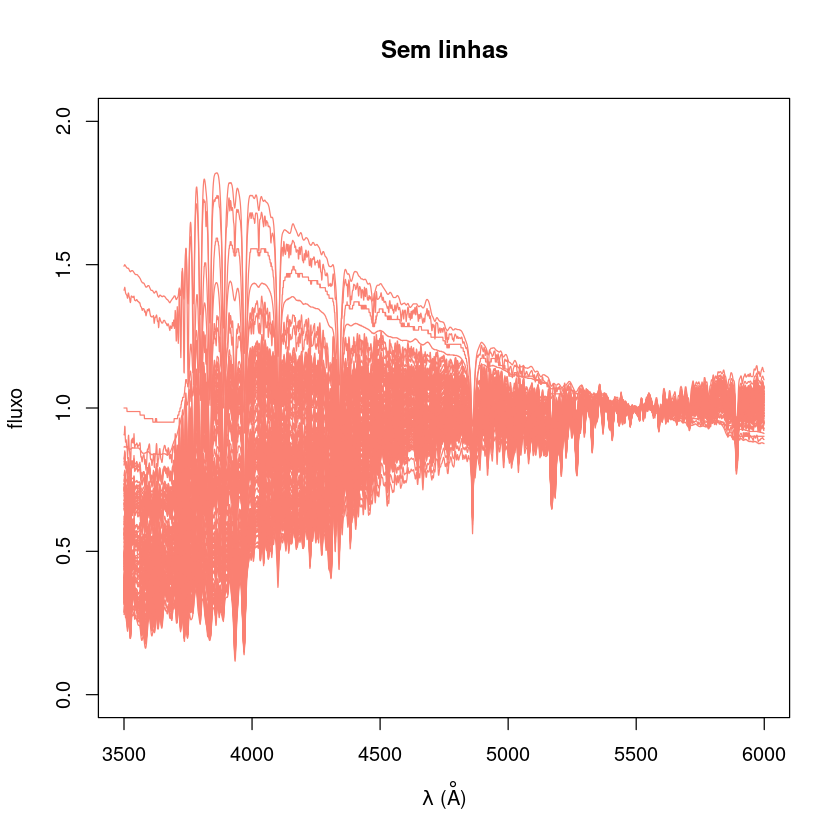

In [180]:
#comprimentos de onda: a primeira coluna
lambdaf_linhas = tab2[,1]

#fluxos: todas as colunas, menos a primeira
fluxos_linhas = tab2[,-1]


par(mfrow = c(1,1))
plot(lambdaf_linhas,fluxos_linhas[,1],type='l',xlab=expression(paste(lambda,' (',ring(A),')')),ylab='fluxo',col='salmon',ylim=c(0,2), main = 'Com linhas')
for(i in 2:ncol(fluxos_linhas)){
lines(lambdaf_linhas,fluxos_linhas[,i],col='salmon')
}


#comprimentos de onda: a primeira coluna
lambdaf = tab3[,1]
#fluxos: todas as colunas, menos a primeira
fluxos = tab3[,-1]

par(mfrow = c(1,1))
plot(lambdaf,fluxos[,1],type='l',xlab=expression(paste(lambda,' (',ring(A),')')),ylab='fluxo',col='salmon',ylim=c(0,2), main = 'Sem linhas')
for(i in 2:ncol(fluxos)){
lines(lambdaf,fluxos[,i],col='salmon')
}


Como podemos ver, nos gráficos anteriores foram plotados os espectros de todas as galáxias juntas, tanto no caso sem linhas quanto no caso com linhas. Importante notar que, em ambos os casos, os espectros estão normalizados em 5500Å.

#### 2.2  Verifique quais são as linhas de emissão mais importantes na região coberta por esses espectros.

Nos plots realizados anteriormente, conseguimos ver fortes linhas de emissão que se apresentam em diferentes galáxias. No gráfico de todos os espectros plotados juntos fica clara 5 linhas de emissão que são repetidamente 

- $\lambda = 3700 Å$
- $\lambda = 4300 Å$
- $\lambda = 4800 Å$
- $\lambda = 4900 Å$
- $\lambda = 5000 Å$

####  2.3. Faça uma análise desses dados com PCA e verifique como muda a variância associada às primeiras componentes principais em relação ao caso sem as linha.

Vamos agora calcular o PCA dos fluxos. Para isso vamos considerar os dados representados como uma matriz onde cada linha é uma galáxia e as colunas são os fluxos nos 2500 comprimentos de onda: essa é a matriz transposta da matrix de fluxos acima.

In [181]:
dados_pca = t(fluxos)
dados_pca_linhas = t(fluxos_linhas)


A coluna correspondente a 5500A∘tem o valor 1 para todas as galáxias, devido à normalização dos espectros. O PCA não gosta disso e vamos, então, remover essa coluna da análise e do vetor com os comprimentos de onda, lambdaf:

In [182]:
#para ver qual é ela:
inorm = which(lambdaf == 5500)
print(inorm)

dados_pca = dados_pca[,-inorm]
dados_pca_linhas = dados_pca_linhas[,-inorm]

dim(dados_pca)
dim(dados_pca_linhas)

# vamos remover esse valor de lambdaf também:
lambdaf=lambdaf[-inorm]
lambdaf_linhas=lambdaf_linhas[-inorm]

[1] 2001


[1]  100 2499

[1]  100 2499

Para o PCA vamos escalonar as variáveis: média zero e variância unitária



In [183]:
pca.fluxos = prcomp(dados_pca, retx=TRUE, center=TRUE, scale=TRUE)

# raiz quadrada dos autovalores
sd = pca.fluxos$sdev

# autovalores
lambda = sd^2

# fraçao da variância explicada
ve = round(cumsum(lambda)/sum(lambda),digits = 3)
ve[1:5]

pca.fluxos_linhas = prcomp(dados_pca_linhas, retx=TRUE, center=TRUE, scale=TRUE)

# raiz quadrada dos autovalores
sd_linhas = pca.fluxos_linhas$sdev

# autovalores
lambda_linhas = sd_linhas^2

# fraçao da variância explicada
ve_linhas = round(cumsum(lambda_linhas)/sum(lambda_linhas),digits = 3)
ve_linhas[1:5]

[1] 0.892 0.937 0.966 0.976 0.984

[1] 0.885 0.930 0.959 0.969 0.977

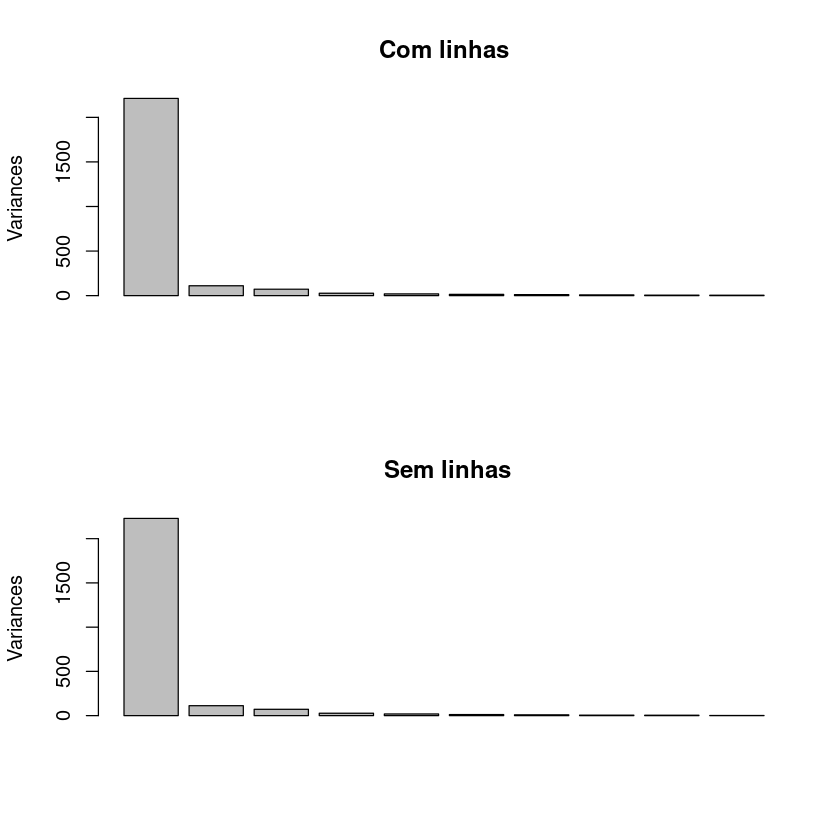

In [189]:
# visualização: scree plot - variância associada a cada componente
par(mfrow = c(2,1))
screeplot(pca.fluxos_linhas, main="Com linhas")
screeplot(pca.fluxos, main=" Sem linhas")

### Análise

Chegamos então a um importante resultado. Podemos ver que para ambos os casos aproximadamente 93% da variância espectral, de um espaço de 2499 dimensões, está contida apenas no plano contido pelas duas primeiras componentes principais!!

Este resultado é uma clara evidência da eficiência do método de PCA, em que uma análise de milhares de dimensões pode ser feita com uma precisão muito alta apenas usando 2 dimensões.

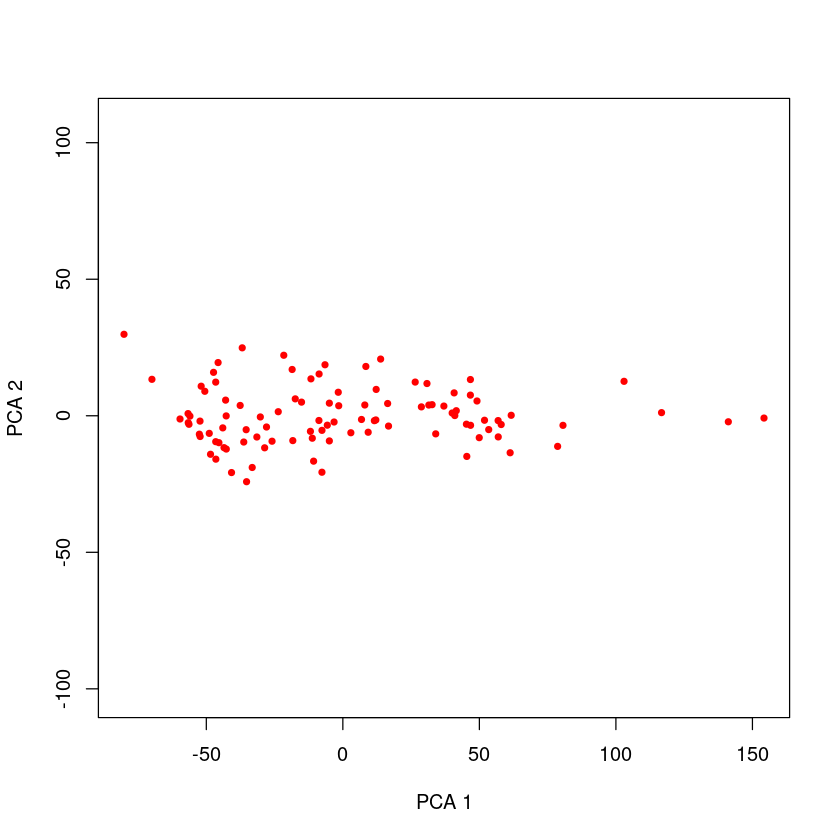

In [126]:
# componentes principais
pc = pca.fluxos$x

# visualização: duas primeiras componentes
par(mfrow = c(1,1))
plot(pc[,1], pc[,2], xlab="PCA 1", ylab="PCA 2",asp=1,pch=20,col='red')

#### 2.4 Examine a reconstrução dos espectros nesse caso.

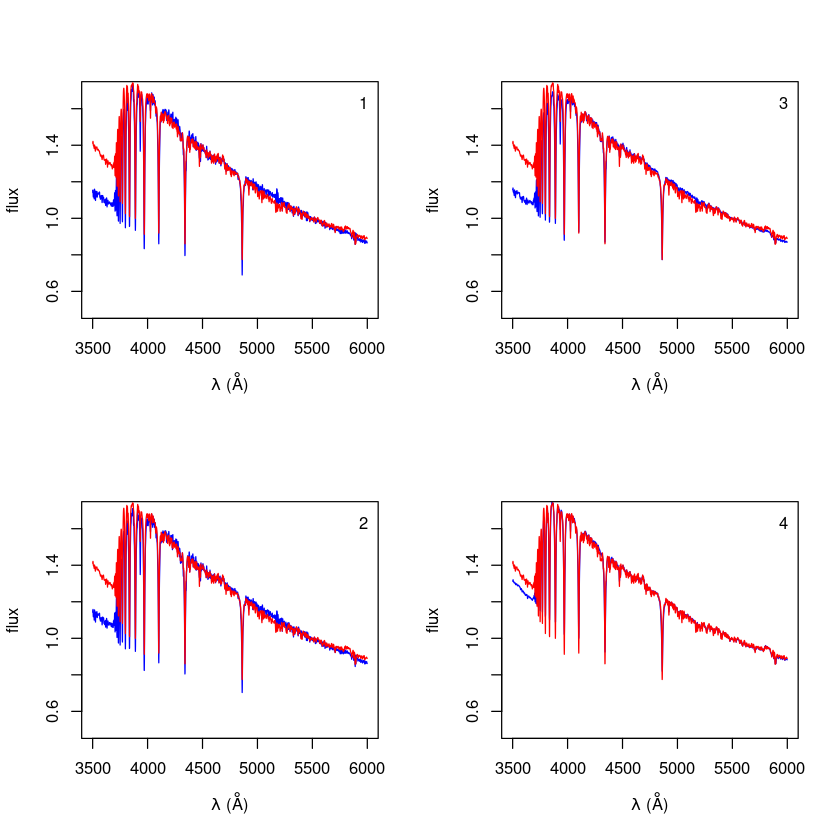

In [192]:
#https://gist.github.com/menugget/7689201
#This function reconstructs a data set using a defined set of principal components.
#arguments "pca" is the pca object from prcomp, "pcs" is a vector of principal components
#to be used for reconstruction (default includes all pcs)
prcomp.recon <- function(pca, ncomp){
  pcs <- seq(1:ncomp)
  recon <- as.matrix(pca$x[,pcs]) %*% t(as.matrix(pca$rotation[,pcs]))
  if(pca$scale[1] != FALSE){
    recon <- scale(recon , center=FALSE, scale=1/pca$scale)
  }
  if(pca$center[1] != FALSE){
    recon <- scale(recon , center=-pca$center, scale=FALSE)
  }
  recon
}

#

# vamos ilustrar a reconstrução do espectro 12 usando de 1 a 4 componentes>
par(mfcol=c(2,2))
obj = 12
for(nComp in 1:4){
Xhat = prcomp.recon(pca.fluxos,nComp)
plot(lambdaf,Xhat[obj,],type='l',xlab=expression(paste(lambda,' (',ring(A),')')),ylab='flux',col='blue',ylim=c(0.5,1.7))
lines(lambdaf,dados_pca[obj,],col='red')
legend('topright',legend = paste(nComp),bty='n')
}

Pela reconstrução do espectro realizada, podemos ver que, desde a primeira componente, o espectro gerado concorda muito bem com espectro real. A medida que são adicionadas mais componentes o espectro começa a encaixar ainda mais, principalmente em pequenos comprimentos de onda, e 4 componentes estão praticamente idênticos.

#### 2.5 Use o pacote dimRed e compare a compressão de dados obtida com PCA e kPCA.

In [195]:
suppressMessages(library(dimRed))

In [196]:
dados <- t(as.matrix(fluxos))
# normalização
#dados <- scale(dados, center = TRUE, scale = TRUE)
dim(dados)

[1]  100 2500

### - Método PCA

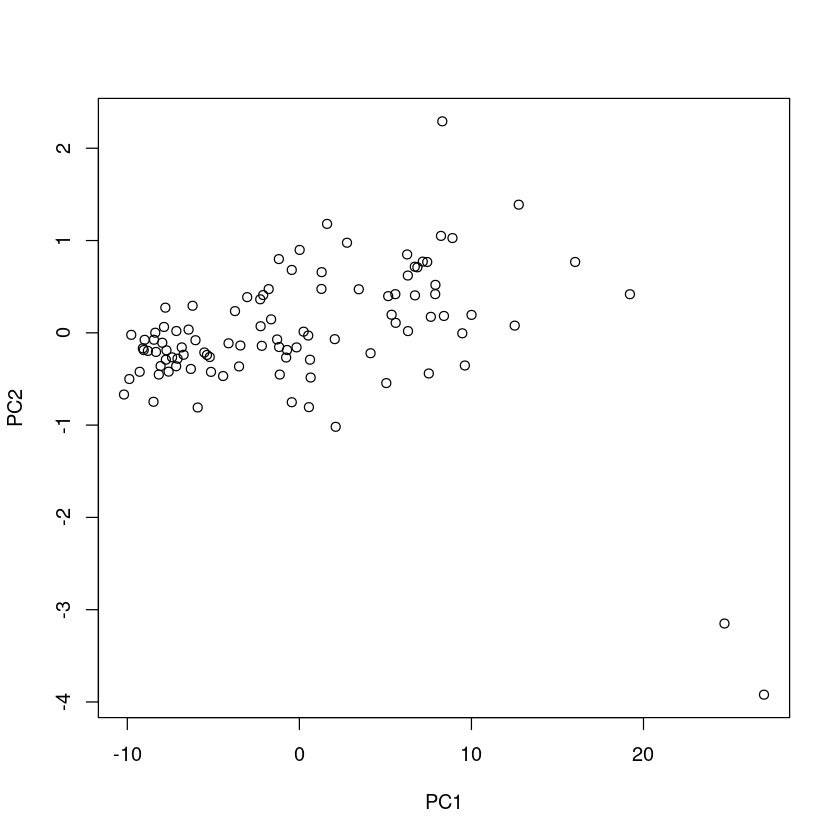

In [197]:
# PCA
emb_PCA <- embed(dados, "PCA")
plot(emb_PCA, type = "2vars")

### - Método kPCA

2023-05-30 13:25:36.622596: Calculating kernel PCA

2023-05-30 13:25:36.687912: Trying to calculate reverse

2023-05-30 13:25:36.701552: DONE



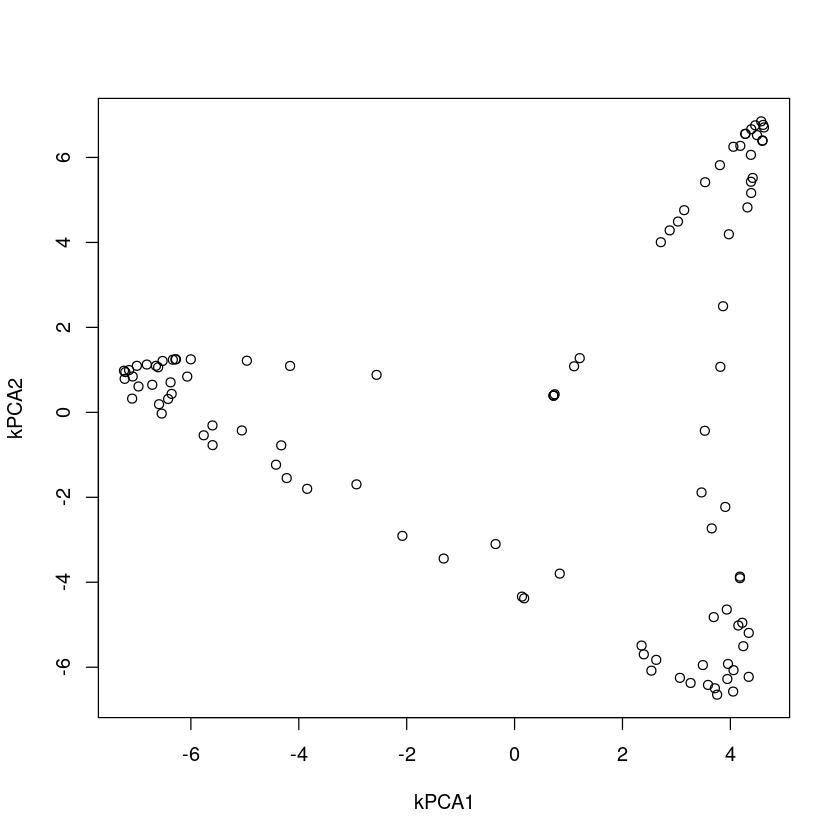

In [199]:
# kPCA  kernel PCA
# extensão não-linear do PCA usando kernels
emb_kPCA <- embed(dados, "kPCA")
plot(emb_kPCA, type = "2vars")

### - Avaliação da redução de dimesnionalidade dos métodos

Neste poonto, iremos utilizar os parâmetros de qualidade da bilbioteca dimRed, que são: Q_local, Q_global e R_NX. Os dois primeiros avaliam localmente e globalmente a qualidade do embedding, enquanto o R_NX avalia a qualidade do embedding geral.

Para ambos os métodos temos então:

In [202]:
# Q_local
quality(emb_PCA,'Q_local')
quality(emb_kPCA,'Q_local')

[1] 0.7739076

[1] 0.6599061

In [203]:
# Q_global
quality(emb_PCA,'Q_global')
quality(emb_kPCA,'Q_global')

14 
0.9770668

25 
0.8156953

In [204]:
# R_NX
quality(emb_PCA,'mean_R_NX')
quality(emb_kPCA,'mean_R_NX')

[1] 0.9505007

[1] 0.4311157

### Conclusão

Podemos ver então, apartir das medida de qualidade do pacote dimRed, que neste exemplo o PCA obteve um nível de compreensão maior do que o kPCA, pois em todos os parâmetros de qualidade ele obteve um valor maior.